# Introduction

In this notebook, we will be looking at data gathered from the esrb.org site. The data details all the descriptors and ratings given to games released for PlayStation4, Xbox One, and Nintendo Switch.

The goal is to train an effective machine learning model to predict a game's rating based on its descriptors. We will be approaching this as a classification problem, although due to the nature of game ratings (E-M), it might also be effective to approach the problem from a regression standpoint.

# Obtain

Here we're making our necessary imports and pulling data from 'esrb_ratings.pkl', which we created in the notebook 'data_gathering.ipynb'. View that notebook to see the web-scraping process.

In [14]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedKFold 

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, plot_confusion_matrix

In [15]:
# load data

df = pd.read_pickle('esrb_ratings.pkl')
df.head()

,title,consoles,descriptors,rating
0,Blizzard Arcade Collection,"[PlayStation 4, Nintendo Switch, Xbox One]","[Blood, Fantasy Violence, Language, Use of Tob...",T
1,Rez Infinite,[PlayStation 4],[Fantasy Violence],E10plus
2,Hotshot Racing,"[PlayStation 4, Nintendo Switch]","[Alcohol Reference, Language, Mild Violence]",E10plus
3,Sea of Solitude : The Director's Cut,[Nintendo Switch],"[Fantasy Violence, Language]",T
4,Ape Out,[Nintendo Switch],"[Blood and Gore, Violence]",T


# Scrub

Using the lists in the 'descriptors' column to one-hot encode the data.

In [16]:
# one-hot encode for consoles and descriptors

descriptors_ohe = pd.get_dummies(df.descriptors.apply(pd.Series).stack()).sum(level=0)

# combine into a single dataframe

df_ohe = pd.concat([df.drop(columns=['descriptors']), descriptors_ohe], axis=1)

df_ohe.head()

,title,consoles,rating,Alcohol Reference,Alcohol and Tobacco Reference,Animated Blood,Animated Blood and Gore,Animated Violence,Blood,Blood and Gore,...,Strong Sexual Content,Suggestive Themes,Tobacco Reference,Use of Alcohol,Use of Alcohol and Tobacco,Use of Drugs,Use of Drugs and Alcohol,Use of Tobacco,Violence,Violent References
0,Blizzard Arcade Collection,"[PlayStation 4, Nintendo Switch, Xbox One]",T,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,Rez Infinite,[PlayStation 4],E10plus,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Hotshot Racing,"[PlayStation 4, Nintendo Switch]",E10plus,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Sea of Solitude : The Director's Cut,[Nintendo Switch],T,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Ape Out,[Nintendo Switch],T,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [17]:
# rearrange columns

cols = list(df_ohe)
rating_col = cols.pop(2)
cols.append(rating_col)
df_ohe = df_ohe.reindex(columns=cols)

df_ohe.head()

,title,consoles,Alcohol Reference,Alcohol and Tobacco Reference,Animated Blood,Animated Blood and Gore,Animated Violence,Blood,Blood and Gore,Cartoon Violence,...,Suggestive Themes,Tobacco Reference,Use of Alcohol,Use of Alcohol and Tobacco,Use of Drugs,Use of Drugs and Alcohol,Use of Tobacco,Violence,Violent References,rating
0,Blizzard Arcade Collection,"[PlayStation 4, Nintendo Switch, Xbox One]",0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,T
1,Rez Infinite,[PlayStation 4],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E10plus
2,Hotshot Racing,"[PlayStation 4, Nintendo Switch]",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E10plus
3,Sea of Solitude : The Director's Cut,[Nintendo Switch],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,T
4,Ape Out,[Nintendo Switch],0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,T


# Explore

First we'll split the data into training and test sets.

In [18]:
cat_dtype = pd.api.types.CategoricalDtype(
    categories=['E', 'E10plus', 'T', 'M'], ordered=True)

X = df_ohe.drop(columns=['title', 'consoles', 'rating'])
y = df.rating.astype(cat_dtype)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

training_data = pd.concat([X_train, y_train], axis=1)

How is the balance of our data?

<BarContainer object of 4 artists>

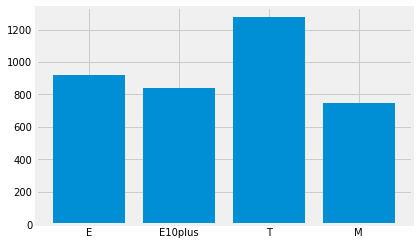

In [19]:
plt.bar(y_train.cat.categories, y_train.value_counts(sort=False))

It isn't totally balanced, but it isn't terribly skewed, either.

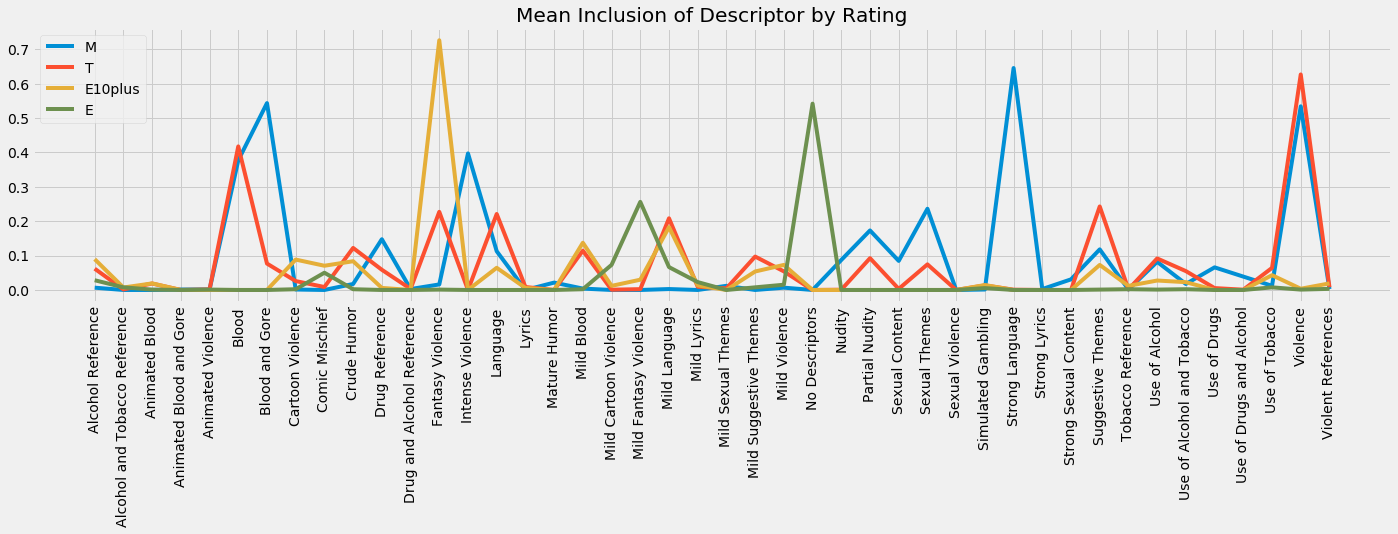

In [20]:
# plot frequency of decriptors
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(20,8))
for r in y_train.cat.categories[::-1]:
    plt.plot(training_data[training_data.rating==r].mean(), label=r)

plt.xticks(rotation=90)
plt.title('Mean Inclusion of Descriptor by Rating')
plt.legend()
plt.tight_layout(pad=2)
plt.savefig('./images/mean_inclusion.png', dpi=fig.dpi)
plt.show()

> Here we can see some general indicators. Blood and Gore/Strong Language are strong indicators for M-rated games. Fantasy Violence is a very strong indicator for E10plus. No Descriptors seems to apply exclusively to E-rated games. Blood and Violence seem very close for T and M ratings.

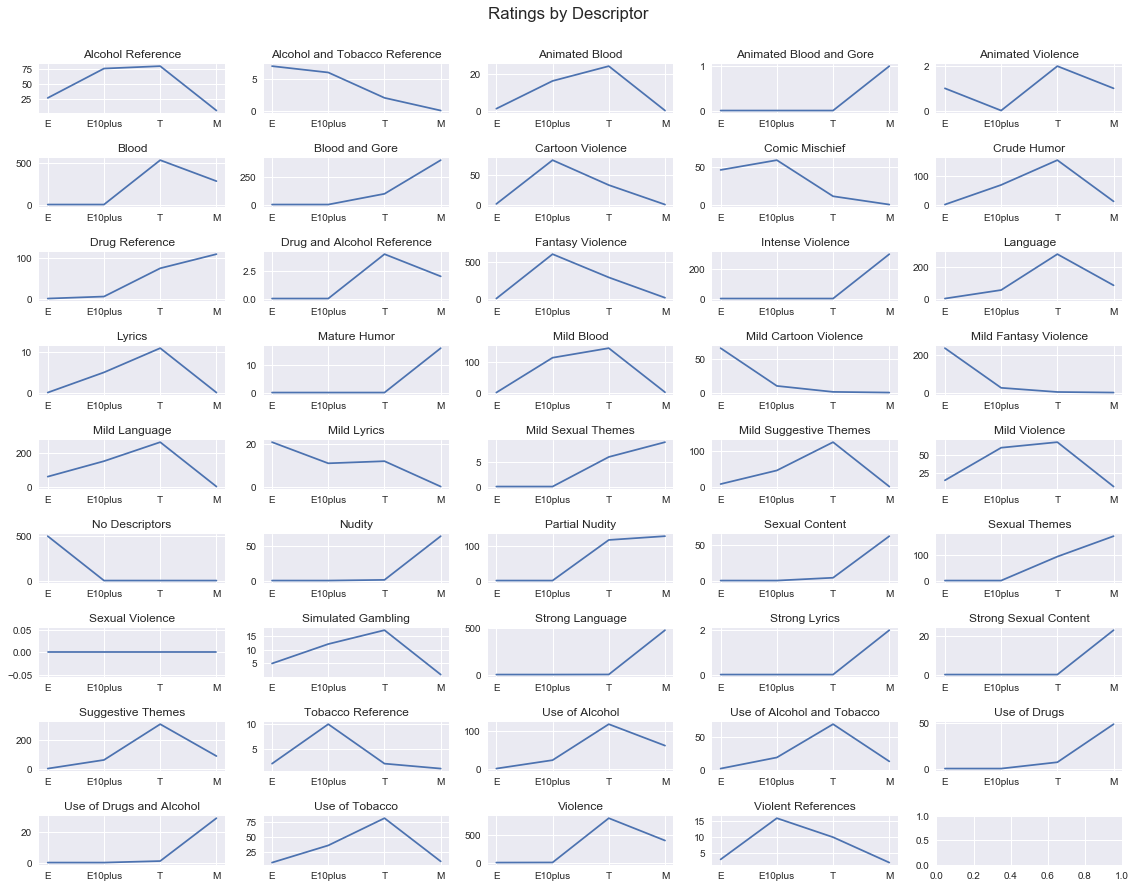

In [21]:
plt.style.use('seaborn')
fig, axs = plt.subplots(9, 5, figsize=(16,13))
ind = 0
for col in X_train.columns:
    ax1 = ind//5
    ax2 = ind%5
    axs[ax1, ax2].plot(y_train.cat.categories, training_data[training_data[col]==1].rating.value_counts(sort=False))
    axs[ax1, ax2].set_title(col)
    ind += 1

fig.suptitle('Ratings by Descriptor')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('./images/ratings_by_descriptor.png', dpi=fig.dpi)
plt.show()

> This certainly shows some trends in some descriptors. Intense Violence tends toward M, while Mild Cartoon Violence tends toward E. These subplots are individually scaled, however, and may be misleading in regard to a descriptor's actual importance. By putting all descriptors on the same scale, we can see that many of these descriptors do not appear very frequently at any rating.

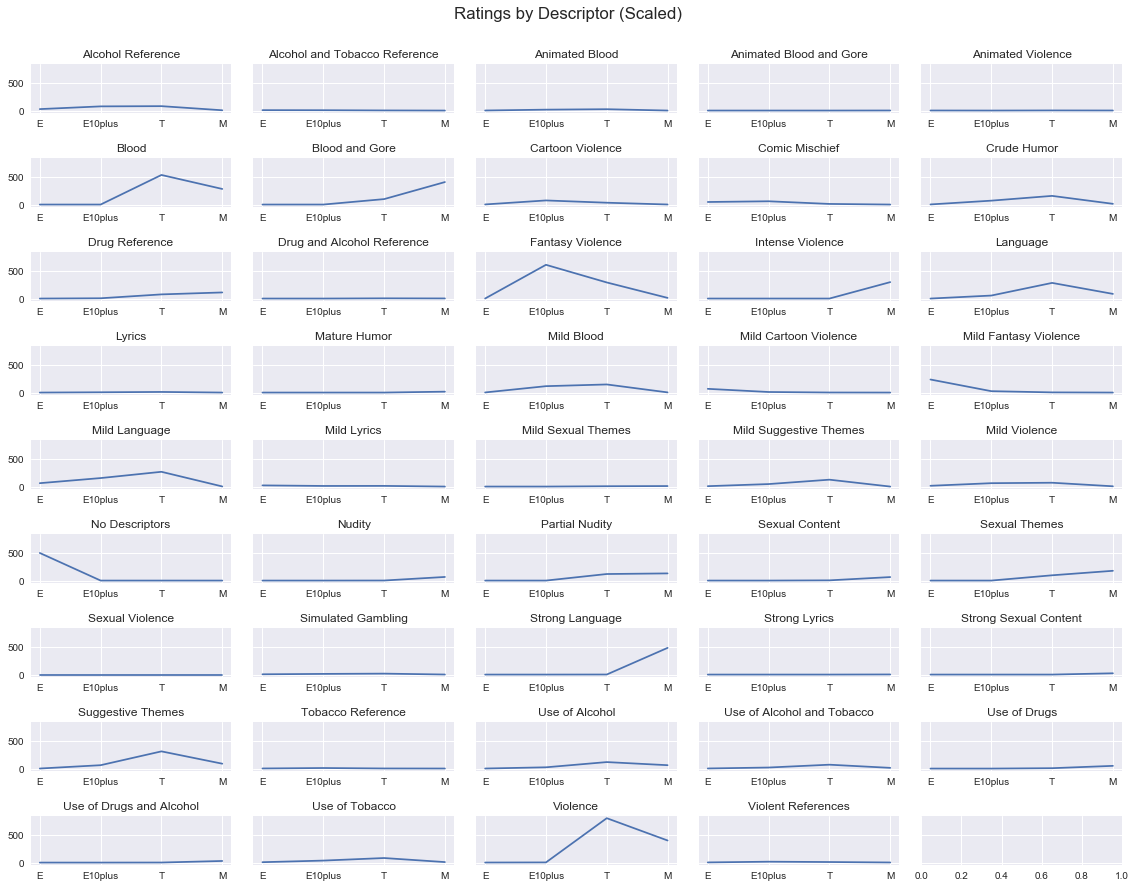

In [22]:
fig, axs = plt.subplots(9, 5, figsize=(16,13), sharey=True)
ind = 0
for col in X_train.columns:
    ax1 = ind//5
    ax2 = ind%5
    axs[ax1, ax2].plot(y_train.cat.categories, training_data[training_data[col]==1].rating.value_counts(sort=False))
    axs[ax1, ax2].set_title(col)
    ind += 1

fig.suptitle('Ratings by Descriptor (Scaled)')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('./images/ratings_by_descriptor_scaled.png', dpi=fig.dpi)
plt.show()

> Some descriptors (such as Blood and Violence) seem to trend in an unintuitive way. If we have trouble modeling with these categorical variables, it might be worth it to combine similar descriptors and assign them a value to make them more continuous.

# Model

Let's test a few models to get a feel for their predictive capabilities for this data.

In [1]:
def test_model(est, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    '''Returns estimator score for Training and Test data'''
    model = est
    model.fit(X_train, y_train)
    print(est)
    print('Training: {}, Test: {}'.format(model.score(X_train, y_train),
                                          model.score(X_test, y_test)))
    print()

NameError: name 'X_train' is not defined

In [24]:
estimators = [DecisionTreeClassifier(), RandomForestClassifier(),
          KNeighborsClassifier(), SVC()]

for estimator in estimators:
    test_model(estimator)

DecisionTreeClassifier()
Training: 0.9305960264900662, Test: 0.8983320095313742

RandomForestClassifier()
Training: 0.9305960264900662, Test: 0.9102462271644162

KNeighborsClassifier()
Training: 0.8908609271523179, Test: 0.8721207307386815

SVC()
Training: 0.9189403973509934, Test: 0.9070691024622717



We can use the classification_report from sklearn to get more detailed information about each model's predictions.

In [25]:
def model_stats(estimator, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    ''' Returns classification report for training and test data'''
    print(estimator)
    print('Training Data:')
    print(classification_report(y_train, estimator.predict(X_train), labels=y.cat.categories))
    print('-----'*10)
    print('Test Data:')
    print(classification_report(y_test, estimator.predict(X_test), labels=y.cat.categories))
    print('-----'*12)
    print('-----'*15)
    print('-----'*12)

for estimator in estimators:
    model_stats(estimator)

DecisionTreeClassifier()
Training Data:
              precision    recall  f1-score   support

           E       0.98      0.98      0.98       917
     E10plus       0.87      0.95      0.90       837
           T       0.93      0.88      0.91      1276
           M       0.95      0.94      0.94       745

    accuracy                           0.93      3775
   macro avg       0.93      0.94      0.93      3775
weighted avg       0.93      0.93      0.93      3775

--------------------------------------------------
Test Data:
              precision    recall  f1-score   support

           E       0.95      0.96      0.95       306
     E10plus       0.82      0.90      0.85       279
           T       0.91      0.83      0.87       425
           M       0.92      0.93      0.93       249

    accuracy                           0.90      1259
   macro avg       0.90      0.91      0.90      1259
weighted avg       0.90      0.90      0.90      1259

----------------------------

Initial tests of vanilla models show promising results for the Random Forest model. Let's try to fine-tune the parameters a bit.

In [26]:
param_grid = {
    'n_estimators': [100, 250, 500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 0.05],
    'max_features': ['auto', None]
}

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
gridsearch = GridSearchCV(RandomForestClassifier(), param_grid, n_jobs=-1, cv=kfold)
gridsearch.fit(X_train, y_train)

gridsearch.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 100}

In [27]:
model_stats(gridsearch.best_estimator_)

RandomForestClassifier(criterion='entropy')
Training Data:
              precision    recall  f1-score   support

           E       0.98      0.97      0.98       917
     E10plus       0.88      0.93      0.90       837
           T       0.92      0.90      0.91      1276
           M       0.95      0.93      0.94       745

    accuracy                           0.93      3775
   macro avg       0.93      0.93      0.93      3775
weighted avg       0.93      0.93      0.93      3775

--------------------------------------------------
Test Data:
              precision    recall  f1-score   support

           E       0.95      0.96      0.96       306
     E10plus       0.85      0.90      0.87       279
           T       0.92      0.87      0.89       425
           M       0.93      0.94      0.94       249

    accuracy                           0.91      1259
   macro avg       0.91      0.92      0.91      1259
weighted avg       0.91      0.91      0.91      1259

---------

91% accuracy with 93% recall on M-rated games, which is the same as our vanilla Random Forest. These are mostly the default values, with the exception of n_estimators. It seems a higher number of trees leads to better predictions.

In [28]:
param_grid = {
    'n_estimators': [250, 500, 750, 1000, 1500]
}

gridsearch2 = GridSearchCV(RandomForestClassifier(), param_grid, n_jobs=-1, cv=kfold)
gridsearch2.fit(X_train, y_train)

gridsearch2.best_params_

{'n_estimators': 750}

Looks like 250 is the best value for n_estimators.

Let's get a better picture of the predictions.

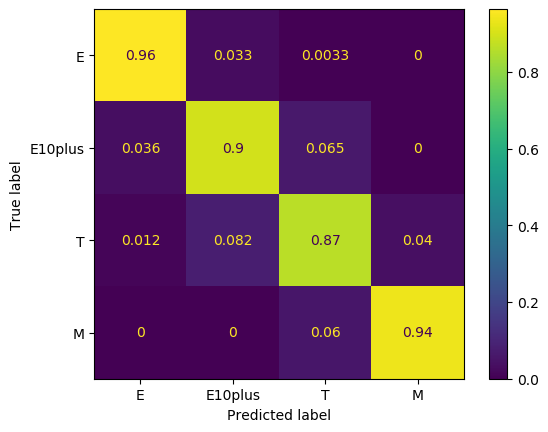

In [29]:
plt.style.use('default')
plot_confusion_matrix(gridsearch.best_estimator_, X_test, y_test, 
                      normalize='true', labels=y.cat.categories)

This seems like a good model. My main concern is not overly misclassifying M-rated games, and this model classifies less than 7% as T and none as E or E10.

I'd like to try out XGBoost to see if it can offer any improvement.

In [30]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

xgb.score(X_test, y_test)

0.8784749801429707

In [31]:
model_stats(xgb)

XGBClassifier(objective='multi:softprob')
Training Data:
              precision    recall  f1-score   support

           E       0.93      0.97      0.95       917
     E10plus       0.81      0.88      0.84       837
           T       0.89      0.83      0.86      1276
           M       0.94      0.90      0.92       745

    accuracy                           0.89      3775
   macro avg       0.89      0.89      0.89      3775
weighted avg       0.89      0.89      0.89      3775

--------------------------------------------------
Test Data:
              precision    recall  f1-score   support

           E       0.93      0.95      0.94       306
     E10plus       0.77      0.90      0.83       279
           T       0.88      0.81      0.84       425
           M       0.94      0.89      0.92       249

    accuracy                           0.88      1259
   macro avg       0.88      0.89      0.88      1259
weighted avg       0.88      0.88      0.88      1259

-----------

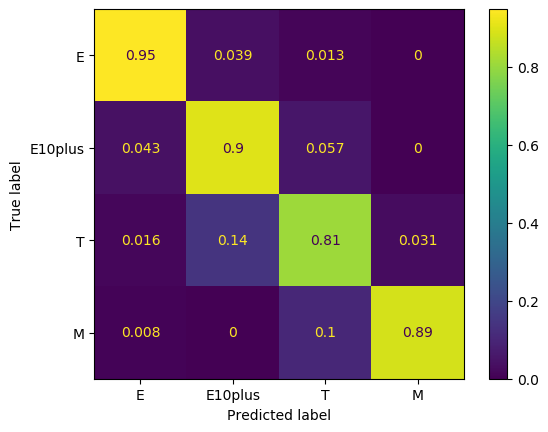

In [32]:
plot_confusion_matrix(xgb, X_test, y_test, 
                      normalize='true', labels=y.cat.categories)

This is definitely not an improvement, but let's tweak the hyperparameters and see what kind of results we can get.

In [33]:
param_grid = {
    'max_depth': [3, 5],
    'booster': ['gbtree', 'dart'],
    'learning_rate': [0.1, 0.2],
    'n_estimators': [100, 500],
}

grid = GridSearchCV(XGBClassifier(), param_grid, n_jobs=-1, cv=kfold)
grid.fit(X_train, y_train)

grid.best_params_

{'booster': 'gbtree',
 'learning_rate': 0.2,
 'max_depth': 5,
 'n_estimators': 100}

In [34]:
grid.score(X_test, y_test)

0.9110405083399523

In [35]:
model_stats(grid.best_estimator_)

XGBClassifier(learning_rate=0.2, max_depth=5, objective='multi:softprob')
Training Data:
              precision    recall  f1-score   support

           E       0.97      0.97      0.97       917
     E10plus       0.86      0.91      0.88       837
           T       0.90      0.88      0.89      1276
           M       0.95      0.92      0.93       745

    accuracy                           0.92      3775
   macro avg       0.92      0.92      0.92      3775
weighted avg       0.92      0.92      0.92      3775

--------------------------------------------------
Test Data:
              precision    recall  f1-score   support

           E       0.96      0.95      0.96       306
     E10plus       0.84      0.91      0.87       279
           T       0.90      0.88      0.89       425
           M       0.95      0.91      0.93       249

    accuracy                           0.91      1259
   macro avg       0.91      0.91      0.91      1259
weighted avg       0.91      0.91 

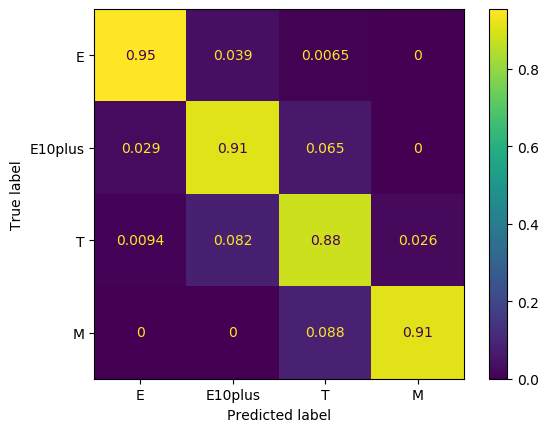

In [36]:
plot_confusion_matrix(grid.best_estimator_, X_test, y_test, 
                      normalize='true', labels=y.cat.categories)

A bit of improvement. Let's tweak a little more.

In [37]:
param_grid = {
    'max_depth': [5,7],
    'learning_rate': [0.2, 0.25],
    'n_estimators': [100, 500]
}

grid = GridSearchCV(XGBClassifier(), param_grid, n_jobs=-1, cv=3)
grid.fit(X_train, y_train)

grid.best_params_

{'learning_rate': 0.25, 'max_depth': 7, 'n_estimators': 500}

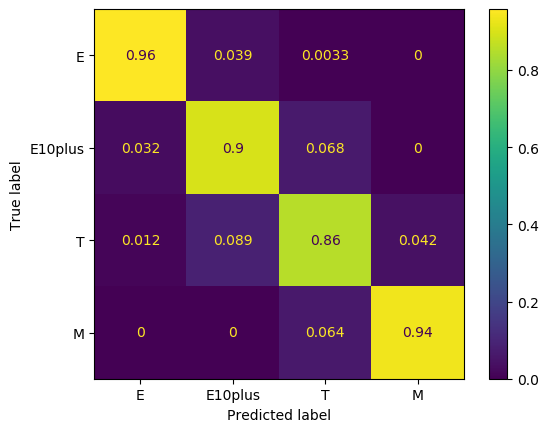

In [38]:
plot_confusion_matrix(grid.best_estimator_, X_test, y_test, 
                      normalize='true', labels=y.cat.categories)

This shows definite improvements to recall for E and M, but at the cost of a small recall dip for E10plus and T. I think it's a good trade.

In [39]:
xgb = XGBClassifier()
param_grid = {
    'max_depth': [7, 9],
    'learning_rate': [0.25, 0.3],
    'n_estimators': [500, 1000]
}
grid_search = GridSearchCV(xgb, param_grid, 
                           n_jobs=-1, cv=kfold)
grid_result=grid_search.fit(X_train, y_train)

print('Best %f using %s' % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('%f (%f) with: %r' % (mean, stdev, param))

Best 0.894298 using {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 500}
0.892973 (0.008731) with: {'learning_rate': 0.25, 'max_depth': 7, 'n_estimators': 500}
0.892710 (0.008796) with: {'learning_rate': 0.25, 'max_depth': 7, 'n_estimators': 1000}
0.892708 (0.008487) with: {'learning_rate': 0.25, 'max_depth': 9, 'n_estimators': 500}
0.892442 (0.009657) with: {'learning_rate': 0.25, 'max_depth': 9, 'n_estimators': 1000}
0.894298 (0.008335) with: {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 500}
0.893770 (0.007603) with: {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 1000}
0.892176 (0.010083) with: {'learning_rate': 0.3, 'max_depth': 9, 'n_estimators': 500}
0.892176 (0.011078) with: {'learning_rate': 0.3, 'max_depth': 9, 'n_estimators': 1000}


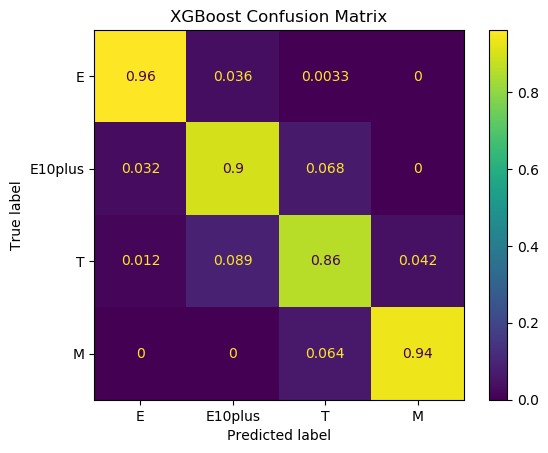

In [40]:
plot_confusion_matrix(grid_result, X_test, y_test, normalize='true', labels=y.cat.categories)
plt.title('XGBoost Confusion Matrix')
plt.savefig('./images/best_confusion_matrix.png', dpi=fig.dpi)

In [41]:
model_stats(grid_result.best_estimator_, X_train, X_test, y_train, y_test)

XGBClassifier(learning_rate=0.3, max_depth=7, n_estimators=500,
              objective='multi:softprob')
Training Data:
              precision    recall  f1-score   support

           E       0.98      0.97      0.98       917
     E10plus       0.88      0.93      0.90       837
           T       0.92      0.90      0.91      1276
           M       0.95      0.92      0.94       745

    accuracy                           0.93      3775
   macro avg       0.93      0.93      0.93      3775
weighted avg       0.93      0.93      0.93      3775

--------------------------------------------------
Test Data:
              precision    recall  f1-score   support

           E       0.95      0.96      0.96       306
     E10plus       0.84      0.90      0.87       279
           T       0.91      0.86      0.88       425
           M       0.93      0.94      0.93       249

    accuracy                           0.91      1259
   macro avg       0.91      0.91      0.91      1259
we

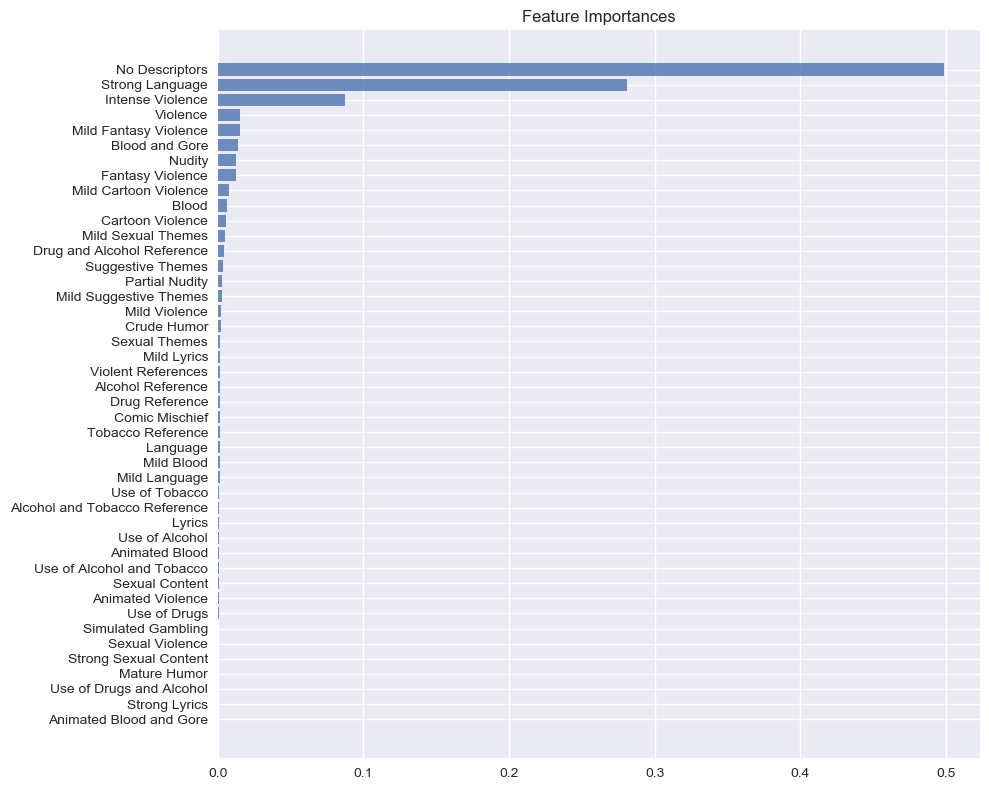

In [42]:
feature_dict = {k:v for (k,v) in zip(X_train.columns, grid_result.best_estimator_.feature_importances_)}
feature_dict = {'Feature': feature_dict.keys(), 'Importance': feature_dict.values()}
fi_df = pd.DataFrame(feature_dict)
fi_df = fi_df.iloc[fi_df.Importance.argsort()]
fi_df
plt.style.use('seaborn')
fig,ax = plt.subplots(figsize=(10,8))
plt.barh(fi_df.Feature, fi_df.Importance, alpha=0.8)
plt.title('Feature Importances')
plt.tight_layout()
plt.savefig('./images/feature_importances', dpi=fig.dpi)
plt.show()

'No Descriptors' is the most important feature by far, followed by 'Strong Language' and 'Intense Violence.' There are seven features with zero importance to the model, however, I hesitate to remove them from the model since some ('Strong Sexual Content', 'Sexual Violence', 'Use of Drugs and Alcohol') seem like they would, in fact, be good indicators of M-rated games should more games with those descriptors be released in the future.

# iNterpret
## Best model: XGBoost

In [43]:
print('Best Model: {}'.format(grid_result.best_estimator_))
print(classification_report(y_test, grid_result.best_estimator_.predict(X_test),
      labels=y.cat.categories))

Best Model: XGBClassifier(learning_rate=0.3, max_depth=7, n_estimators=500,
              objective='multi:softprob')
              precision    recall  f1-score   support

           E       0.95      0.96      0.96       306
     E10plus       0.84      0.90      0.87       279
           T       0.91      0.86      0.88       425
           M       0.93      0.94      0.93       249

    accuracy                           0.91      1259
   macro avg       0.91      0.91      0.91      1259
weighted avg       0.91      0.91      0.91      1259



After some tweaking, our best model is XGBoost. With this model, we get 94% recall on M-rated games, which I believe is the most important label to classify correctly. As we can see from the confusion matrix, however, there is some confusion between T and M ratings. We should look into the data to see if we can identify the problem.

## Identifying the reasons for misclassification

In [44]:
# training data with predictions attached
training_with_preds = training_data.copy()
training_with_preds['prediction'] = grid_result.predict(X_train)

training_with_preds.head()

,Alcohol Reference,Alcohol and Tobacco Reference,Animated Blood,Animated Blood and Gore,Animated Violence,Blood,Blood and Gore,Cartoon Violence,Comic Mischief,Crude Humor,...,Tobacco Reference,Use of Alcohol,Use of Alcohol and Tobacco,Use of Drugs,Use of Drugs and Alcohol,Use of Tobacco,Violence,Violent References,rating,prediction
1881,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,M,T
2346,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,E,E
525,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,T,T
1215,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,E10plus,E10plus
603,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,T,M


In [45]:
# dataframe of misclassified games
wrong_df = training_with_preds[training_with_preds['rating']!=training_with_preds['prediction']]
wrong_df.shape

(267, 46)

267 games misclassified in the training set. What are the prominent descriptors in these games?

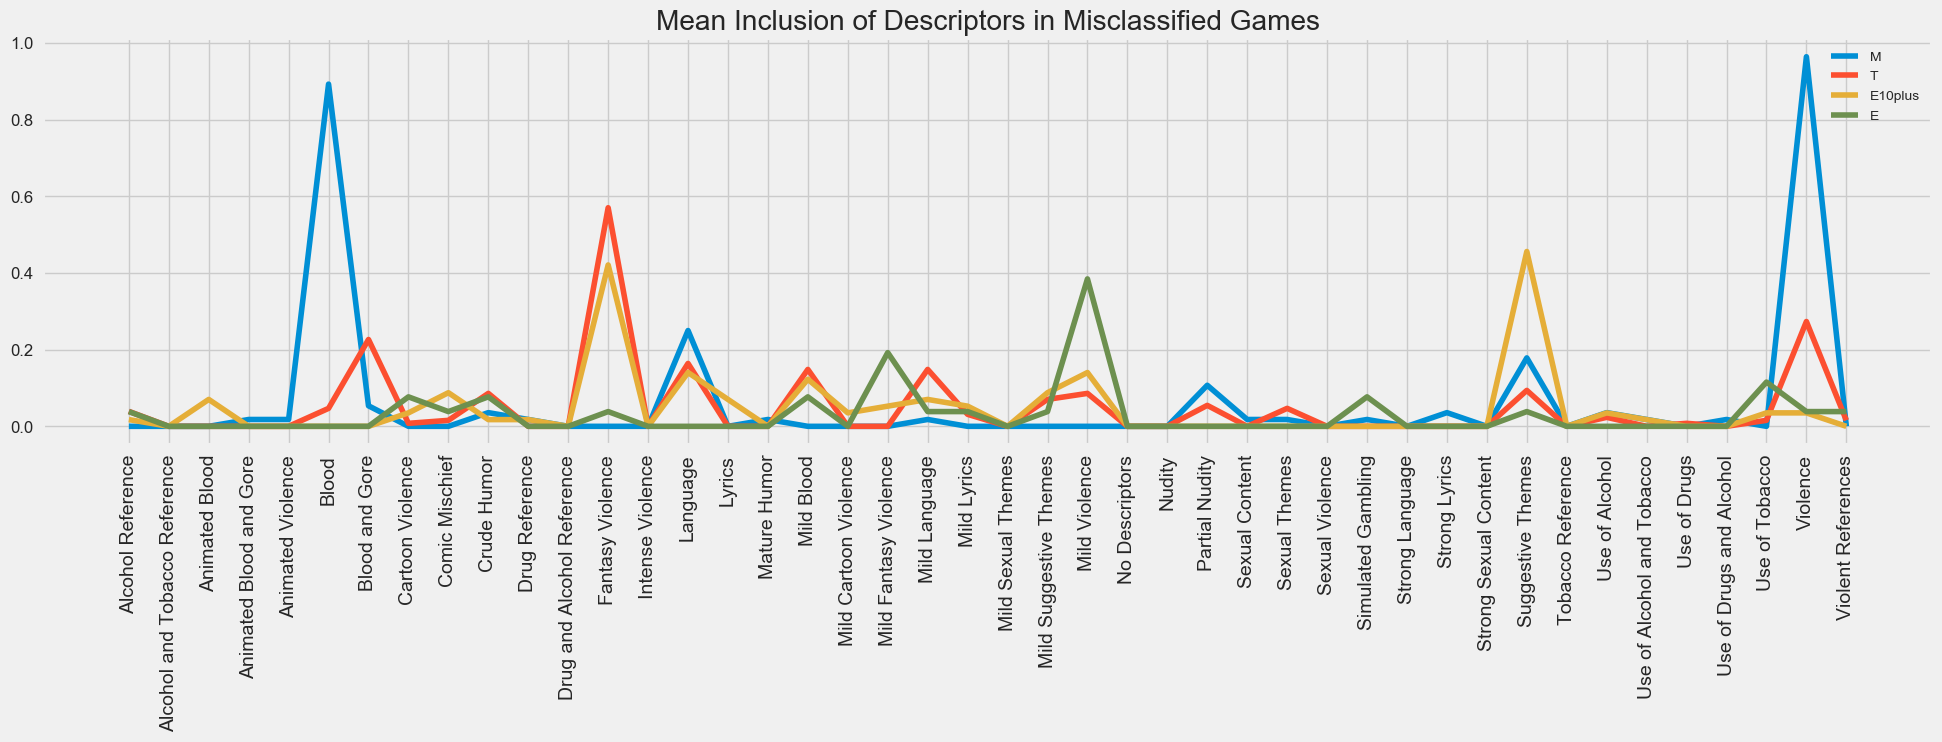

In [46]:
# plot of descriptor frequency
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(20,8))
for r in y.cat.categories[::-1]:
    plt.plot(wrong_df.drop(columns=['prediction'])[wrong_df.rating==r].mean(), label=r)

plt.xticks(rotation=90)
plt.title('Mean Inclusion of Descriptors in Misclassified Games')
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.legend()
plt.tight_layout(pad=2)
plt.savefig('./images/mean_misclassified.png', dpi=fig.dpi)
plt.show()

> We can see here that about 90% of misclassified M-rated games contained the 'Blood' descriptor and about 95% percent had the 'Violence' descriptor. 'Fantasy Violence' was used as a descriptor for about 60% of T-rated games and 40% of E10plus games. About 40% of misclassified E-rated games had the descriptor 'Mild Violence.' There are also a decent spike for 'Suggestive Themes' in E10plus games.

Since 'Blood' and 'Violence' are the most promiment for M-rated games, let's look at the games that contain those descriptors.

## A deeper look into Blood and Violence

In [47]:
# dataframe of misclassified games containing blood or violence
bv_df = wrong_df[(wrong_df['Blood']==1) | (wrong_df['Violence']==1)]
# filter out columns that are no longer relevant
bv_df = bv_df.loc[:, (bv_df != 0).any(axis=0)]
display(bv_df.head())
bv_df.shape

,Blood,Blood and Gore,Crude Humor,Drug Reference,Language,Mature Humor,Mild Language,Partial Nudity,Sexual Content,Sexual Themes,Strong Lyrics,Suggestive Themes,Use of Alcohol,Use of Alcohol and Tobacco,Use of Drugs,Use of Drugs and Alcohol,Violence,rating,prediction
1881,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,M,T
603,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,T,M
3113,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,M,T
107,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,M,T
4720,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,M,T


(92, 19)

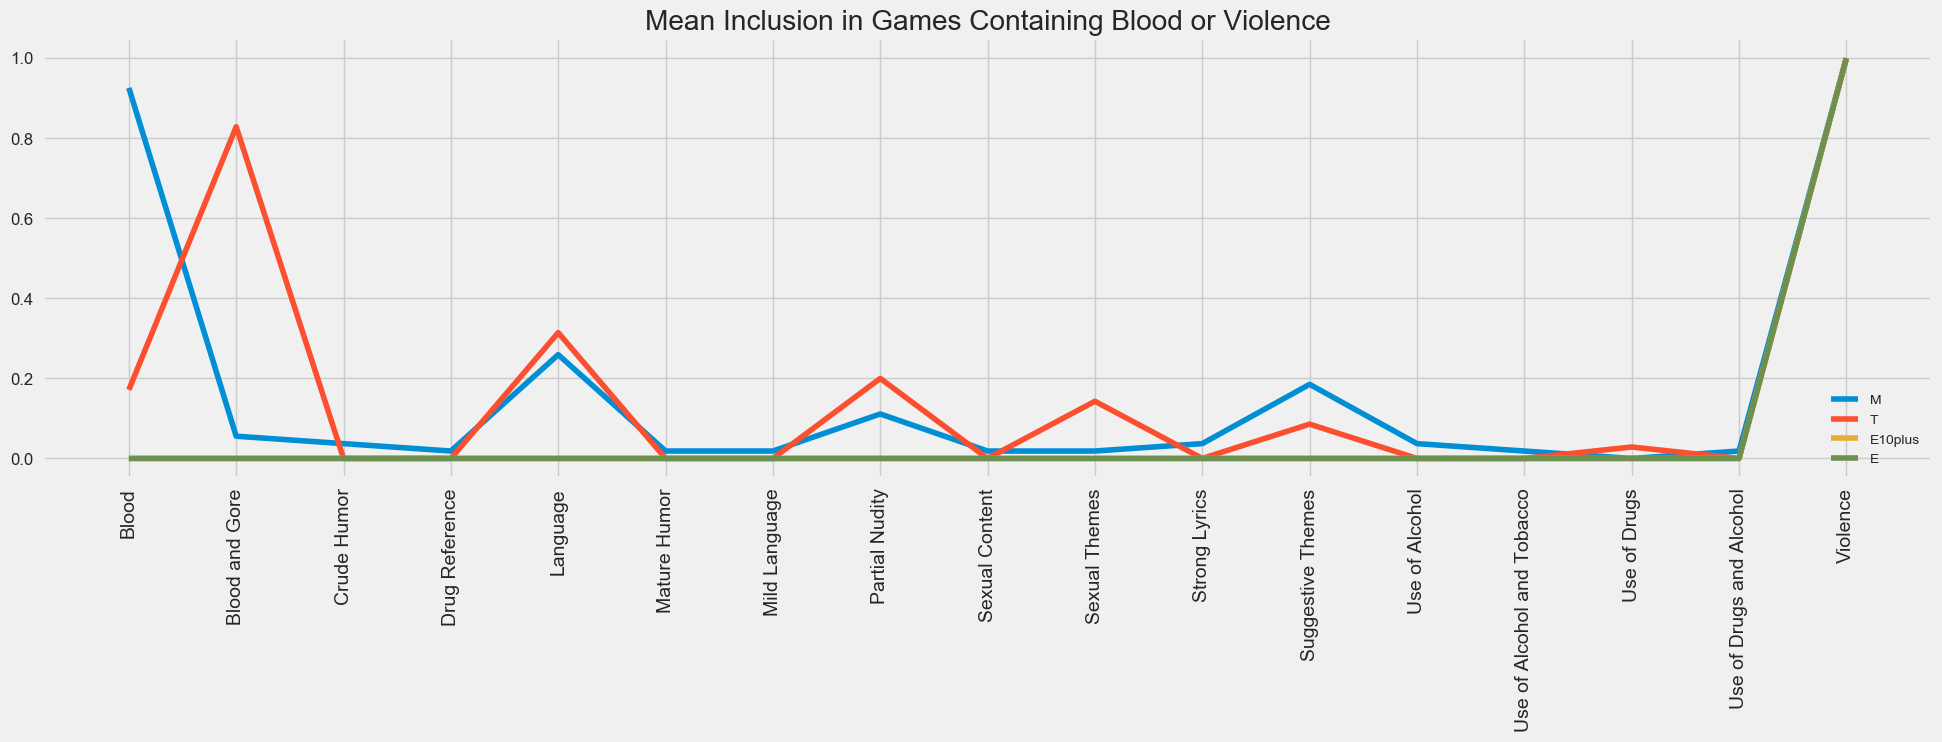

In [48]:
# plot frequency
fig, ax = plt.subplots(figsize=(20,8))
for r in y.cat.categories[::-1]:
    plt.plot(bv_df.drop(columns=['prediction'])[bv_df.rating==r].mean(), label=r)

plt.xticks(rotation=90)
plt.title('Mean Inclusion in Games Containing Blood or Violence')
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.legend()
plt.tight_layout(pad=2)
plt.savefig('./images/mean_blood_or_violence.png', dpi=fig.dpi)
plt.show()

> This graph shows mean descriptor inclusion in all misclassified games containing 'Blood' or 'Violence.' As we can see, most misclassified M-ratings contain 'Blood,' while an almost equal percentage of misclassified T-ratings contain 'Blood and Gore.'

What about games where 'Blood' and 'Violence' are the only descriptors?

In [49]:
# dataframe of all training data including blood and violence
bv_df2 = training_with_preds[(training_with_preds['Blood']==1) & training_with_preds['Violence']==1]
# drop any rows containing any other descriptor
bv_df2 = bv_df2.drop(index=[bv_df2.index[i] for i in range(len(bv_df2))
                            if bv_df2.loc[:, 'Alcohol Reference':'Violent References'].iloc[i].sum()!=2])
bv_df2

,Alcohol Reference,Alcohol and Tobacco Reference,Animated Blood,Animated Blood and Gore,Animated Violence,Blood,Blood and Gore,Cartoon Violence,Comic Mischief,Crude Humor,...,Tobacco Reference,Use of Alcohol,Use of Alcohol and Tobacco,Use of Drugs,Use of Drugs and Alcohol,Use of Tobacco,Violence,Violent References,rating,prediction
4397,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,T,T
1394,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,T,T
4601,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,M,T
4758,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,T,T
2863,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,T,T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3613,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,T,T
2822,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,T,T
3442,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,M,T
1030,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,M,T


In [50]:
# rows with correct predictions
bv_df2[bv_df2.rating == bv_df2.prediction].rating.value_counts()

T          152
M            0
E10plus      0
E            0
Name: rating, dtype: int64

177 games from our training set have 'Blood' and 'Violence' as their only descriptors. Our model correctly identified 152 of them as T-rated games, but there was no way for the model to identify the other 25 as being M-rated games.

## What have we learned?

While the XGBoost model is very effective at classifying games based on the given descriptors, it is limited by inconsistent labeling by the ESRB. As we saw above, games with identical descriptors are sometimes given different ratings. 

This doesn't seem ideal, as it puts the burden on the consumer to determine for themselves what those descriptors might mean in the context of the overall rating. If a game is rated T for Blood and Violence, how is that different from a game rated M for Blood and Violence? Rather that put that burden on the consumer, the ESRB should focus on a more unified and transparent rating system.

## Recommendation

The ESRB seems to default to more generalized descriptors in spite of the fact that that there are more specific descriptors available. Better, more frequent use of these more descriptive content warnings would be helpful both to consumers and the predictive algorithm.

Another option would be to use more descriptors. What sets an M-rated game with Blood and Violence apart from a T-rated game? It could be Dark Themes, Horror, or Disturbing Imagery. Anything that could cement the reason that one game is rated for more mature audiences than the other would be helpful.